# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fÃ©dÃ©rale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
    - Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
    - Answer the previous question aggregating the data by (c) country and (d) region.
    
 Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

## Question 1 and 2 Plan:

### Thought process and Implementation plan:

#### Create the dataframe:

##### For topuniversities.com
1. We use Postman and the interceptor to capture the HTTP request traffic and be able to choose the json file that contains the ranking.  
  1. Specifically, we request https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508228964836  
  
2. Using the requests library, we can easily parse the json to get a dictionary with key, value pairs for rank, country, region, and url for the details page.  

3. We loop through the top 200 universities, and at each university, we request the details page using the obtained url.  

  1. (for example, https://www.topuniversities.com/universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl).  
  
4. On the details page which is an HTML file, we parse the HTML and retrieve the number of faculty -- international and total, and number of students -- international and total.  
  * The NYU details page does not have any information on total, international students and faculty numbers. We replace these cells in the dataframe with NaN.
  * There is no international faculty in Indian Institute of Science (IISc) Bangalore (top_uni), so we replace this cell with NaN.

5. We convert all numbers from string to float to make our analysis easier.  

##### For timeshighereducation.com
1. A similar process is carried out as above, with the data located here: https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json; however, in this case, all the information is in the main page, so we don't need to request another page for each university. We parse the json file and extract the information for 
  * rank
  * name
  * aliases
  * location (this is country)
  * stats_number_students
  * stats_student_staff_ratio
  * stats_pc_intl_students 
  * *** There is no region information but we can obtain this from our topuniversities dataframe.

#### Determine the best universities based on faculty : students and international students : total students:
1. We compute the total faculty to total student ratios.
2. We use df.sort_values on the computed ratios and sort by descending values. We assume higher faculty:student ratios mean better university.
3. We follow the above two steps for international student ratios.

#### Aggregate the data by country and region
1. We use the df.groupby function to group by country and then take the mean of 1) faculty : students or 2) international students : total students within each country group.
2. Same is done for the region.

In [286]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

### Question 1.

We first crawl data from the webpages, including the details page of universities we are interested in, and then put it into a dataframe.

In [287]:
# Request the main page containing the rank
req1 = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508228964836')
body = req1.json()
body_data = body['data']

# The fields we are interested in
# Global data
dict_fields = {'Name':    'title',
               'Rank':    'rank_display',
               'Country': 'country',
               'Region':  'region'}
# Detail pages
dict_class_names = {'No. of International Faculty':  'inter faculty',
                    'No. of Total Faculty':          'total faculty',
                    'No. of International Students': 'total inter',
                    'No. of Total Students':         'total student'}

# The helper function that gets information from details pages
def get_numbers(soup, class_name):
    try:
        num = float(soup.find(class_=class_name).find(class_='number').string[1:-1].replace(",", ""))
    except:
        # If there's no data, print an error and fall back to NaN
        num = float("NaN")
        school_name = soup.find(class_ = "qs-profile-2 content panel-panel").find_next('h1').string
        print("Error in " + school_name + ": Can't find " + class_name)
    return num

# Add data of each university one by one
rank_list = []
for i in range(200):
    # Request the details page
    details = requests.get('https://www.topuniversities.com' + body_data[i]['url'])
    html_body = details.text
    # Parse the HTML
    soup = BeautifulSoup(html_body, 'html.parser')
    
    dict_school = {}
    for field, field_name in dict_fields.items():
        dict_school[field] = body_data[i][field_name]
    for field, class_name in dict_class_names.items():
        dict_school[field] = get_numbers(soup, class_name)
    
    rank_list.append(dict_school)
    
# Use dictionary to create Dataframe for data from topuniversities.com
top_ranking_universities = pd.DataFrame.from_dict(rank_list)


Error in New York University (NYU): Can't find inter faculty
Error in New York University (NYU): Can't find total faculty
Error in New York University (NYU): Can't find total inter
Error in New York University (NYU): Can't find total student
Error in Indian Institute of Science (IISc) Bangalore: Can't find inter faculty


In [288]:
# Convert string values under Rank to int
top_ranking_universities['Rank'] = top_ranking_universities.Rank.apply(lambda num: int(num.replace('=', '')))

#### The New York University's page has no data on the number of faculty and students. The Indian Institute of Science has no data on international faculty.

In [289]:
top_ranking_universities.head()

,Country,Name,No. of International Faculty,No. of International Students,No. of Total Faculty,No. of Total Students,Rank,Region
0,United States,Massachusetts Institute of Technology (MIT),1679.0,3717.0,2982.0,11067.0,1,North America
1,United States,Stanford University,2042.0,3611.0,4285.0,15878.0,2,North America
2,United States,Harvard University,1311.0,5266.0,4350.0,22429.0,3,North America
3,United States,California Institute of Technology (Caltech),350.0,647.0,953.0,2255.0,4,North America
4,United Kingdom,University of Cambridge,2278.0,6699.0,5490.0,18770.0,5,Europe


In [290]:
# Add new columns and compute the faculty to student and international student to total student ratios
top_ranking_universities['Faculty : Students'] = \
    top_ranking_universities['No. of Total Faculty']/ \
    top_ranking_universities['No. of Total Students']
top_ranking_universities['International Students : Total Students'] = \
    top_ranking_universities['No. of International Students']/ \
    top_ranking_universities['No. of Total Students']

top_ranking_universities.head()

,Country,Name,No. of International Faculty,No. of International Students,No. of Total Faculty,No. of Total Students,Rank,Region,Faculty : Students,International Students : Total Students
0,United States,Massachusetts Institute of Technology (MIT),1679.0,3717.0,2982.0,11067.0,1,North America,0.269450,0.335863
1,United States,Stanford University,2042.0,3611.0,4285.0,15878.0,2,North America,0.269870,0.227422
2,United States,Harvard University,1311.0,5266.0,4350.0,22429.0,3,North America,0.193945,0.234785
3,United States,California Institute of Technology (Caltech),350.0,647.0,953.0,2255.0,4,North America,0.422616,0.286918
4,United Kingdom,University of Cambridge,2278.0,6699.0,5490.0,18770.0,5,Europe,0.292488,0.356899


### Question 1 (a): Which are the best universities in term of ratio between faculty members and students?

In [291]:
# Sort the dataframe by faculty-student ratio in descending order 
top_uni_by_facstud = top_ranking_universities.sort_values(
    by = 'Faculty : Students',
    ascending = False
)
top_uni_by_facstud[['Rank', 'Name', 'Faculty : Students']].head(10)

,Rank,Name,Faculty : Students
3,4,California Institute of Technology (Caltech),0.422616
15,16,Yale University,0.398323
5,6,University of Oxford,0.342292
4,5,University of Cambridge,0.292488
16,17,Johns Hopkins University,0.276353
1,2,Stanford University,0.269870
0,1,Massachusetts Institute of Technology (MIT),0.269450
185,186,University of Rochester,0.266604
18,19,University of Pennsylvania,0.266437
17,18,Columbia University,0.247115


In [292]:
# We define a function to make our bar plots
def plot_bar(column_name, number_bars, df, y_ticks_label, errs=np.array([0])):
    # Get data to plot
    idx = np.arange(number_bars)
    val = df.head(number_bars)[column_name]
    
    fig, ax = plt.subplots()
    fig.suptitle(column_name, fontsize=20)
    fig.set_size_inches(7, 6)
    ax.barh(idx, val, align='center')
    ax.set_xlabel('Ratio', fontsize=20)
    ax.set_yticks(np.arange(number_bars))
    ax.set_yticklabels(y_ticks_label, fontsize=12)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.xaxis.grid()
    # Plot errors if needed
    if len(errs) > 1:
        errs[np.isnan(errs)]=0
        ax.errorbar(val, idx, xerr=errs[:number_bars], ecolor='r', fmt='none')
    plt.show()

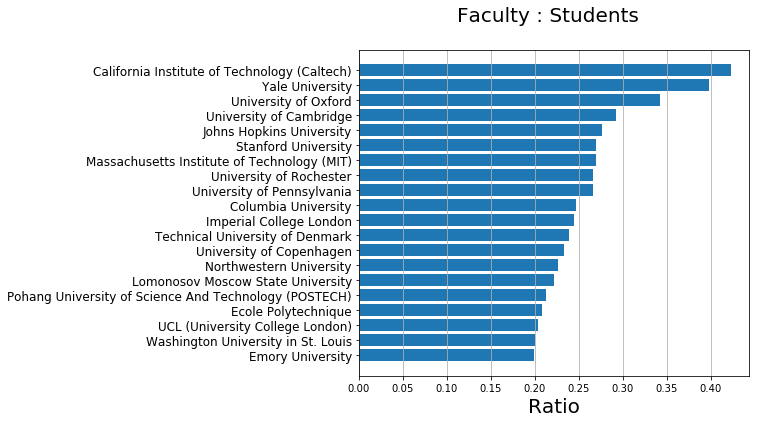

In [293]:
# Plot the faculty:student ratio for the data from topuniversities.com
plot_bar('Faculty : Students', 20, top_uni_by_facstud, top_uni_by_facstud.Name)

### Question 1 (b): Which are the best universities in term of ratio of international students?

In [294]:
# Sort by the international students ratio
top_uni_by_interstud = top_ranking_universities.sort_values(
    by = 'International Students : Total Students',
    ascending = False
)
top_uni_by_interstud[['Rank', 'Name', 'International Students : Total Students']].head(10)

,Rank,Name,International Students : Total Students
34,35,London School of Economics and Political Scien...,0.691393
11,12,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,8,Imperial College London,0.543567
198,200,Maastricht University,0.502533
47,47,Carnegie Mellon University,0.478062
6,7,UCL (University College London),0.477928
91,92,University of St Andrews,0.457955
41,41,The University of Melbourne,0.427434
126,127,Queen Mary University of London,0.421816
25,26,The University of Hong Kong,0.407144


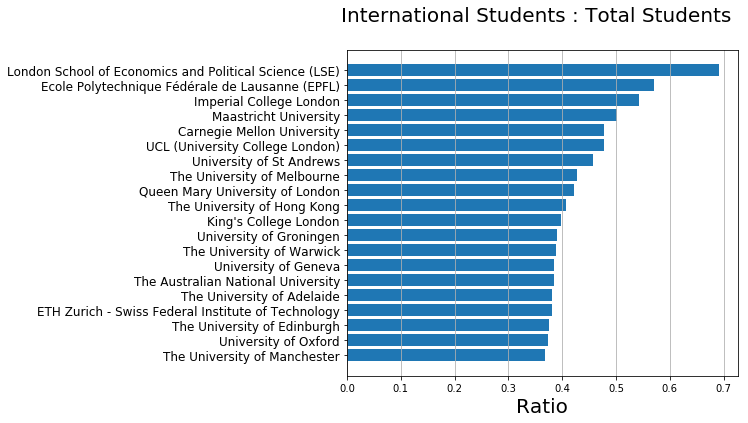

In [295]:
# Plot the international:total student ratio
plot_bar('International Students : Total Students', 20, top_uni_by_interstud, top_uni_by_interstud.Name)

### Question 1 (c): Answer the previous question aggregating the data by country.
##### We computed the average of the ratios of all universities in each country

In [296]:
# Group data by country and compute the average of all fields
by_country = top_ranking_universities.groupby('Country').mean()
by_country['std'] = top_ranking_universities.groupby('Country').std()['Faculty : Students']

# Sort by average faculty : student ratio across countries
country_facstud = by_country.sort_values(
    by = 'Faculty : Students',
    ascending = False
)

country_facstud[['Faculty : Students', 'std']].head()

,Faculty : Students,std
Country,,
Russia,0.221910,NaN
Denmark,0.186580,0.085149
Saudi Arabia,0.175828,NaN
Singapore,0.162279,0.008861
Japan,0.155840,0.023966


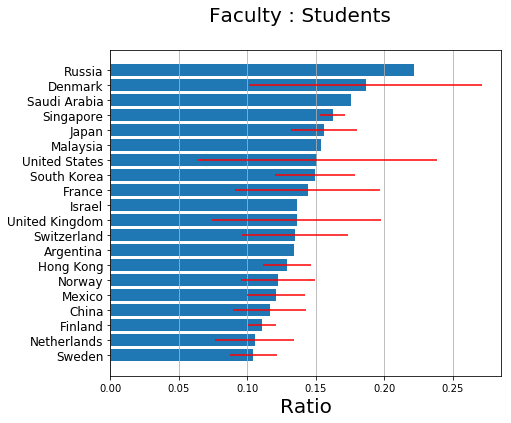

In [297]:
plot_bar('Faculty : Students', 20, country_facstud, country_facstud.index, country_facstud['std'])

In [298]:
# Sort by average international students ratios across countries
country_interstud = by_country.sort_values(
    by = 'International Students : Total Students',
    ascending = False
)
country_interstud[['International Students : Total Students']].head()

,International Students : Total Students
Country,
United Kingdom,0.351308
Australia,0.346878
Switzerland,0.313816
Hong Kong,0.312148
Austria,0.306095


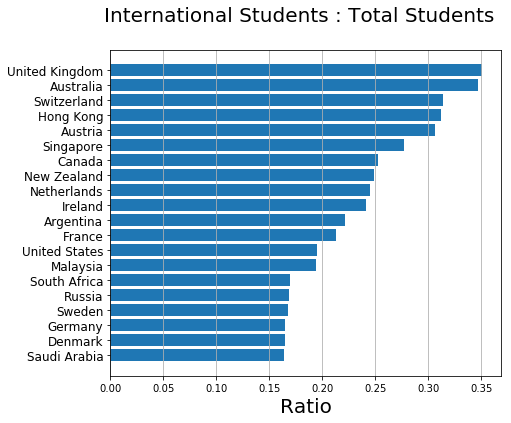

In [299]:
plot_bar('International Students : Total Students', 20, country_interstud, country_interstud.index)

### Question 1 (d): Answer the previous question aggregating the data by region.

Same as above, but grouping by region.

In [300]:
# Group data by Region and compute the average of all fields
by_region = top_ranking_universities.groupby('Region').mean()

# Sort by average faculty : student ratio across regions
region_facstud = by_region.sort_values(
    by = 'Faculty : Students',
    ascending = False
)

region_facstud[['Faculty : Students']]

,Faculty : Students
Region,
North America,0.144831
Asia,0.134673
Europe,0.120003
Latin America,0.096779
Africa,0.088450
Oceania,0.075003


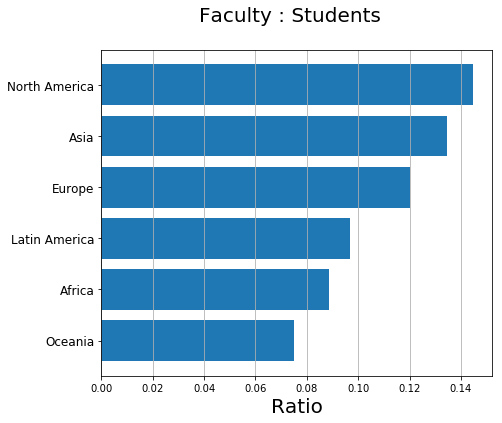

In [301]:
plot_bar('Faculty : Students', 6, region_facstud, region_facstud.index)

In [302]:
# Sort by average international students : student ratio across regions
region_interstud = by_region.sort_values(
    by = 'International Students : Total Students',
    ascending = False
)
region_interstud[['International Students : Total Students']]

,International Students : Total Students
Region,
Oceania,0.329077
Europe,0.245932
North America,0.202437
Africa,0.169703
Asia,0.132394
Latin America,0.071751


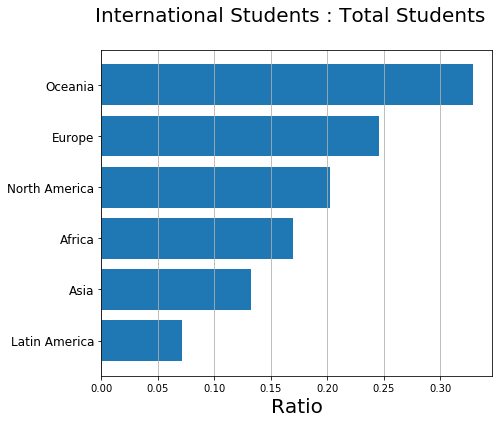

In [303]:
plot_bar('International Students : Total Students', 6, region_interstud, region_interstud.index)

### Question 2: Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

In [304]:
# Fetch the data
req_times = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
body_times = req_times.json()
body_times_data = body_times['data']

The Times Higher Education ranking defines "Staff" as "those involved in teaching or research" which matches our definition of "Faculty"

In [305]:
# Parse the data and build a dataframe
rank_list_times = []

for i in range(200):
    name = body_times_data[i]['name']
    aliases = body_times_data[i]['aliases']
    rank = body_times_data[i]['rank'].strip('=')
    location = body_times_data[i]['location']
    
    # Python doesn't like commas as thousands separators, remove them
    num_students = int(body_times_data[i]['stats_number_students'].replace(",",""))
    faculty_students = 1 / float(body_times_data[i]['stats_student_staff_ratio'])
    
    # Same for percentage signs. In addition we need to divide by 100
    perc_international = int(body_times_data[i]['stats_pc_intl_students'].strip("%"))/100.0
    
    rank_list_times.append({'Name': name,
                            'Aliases': aliases,
                            'Rank': rank,
                            'Country': location,
                            'No. of Total Students': num_students,
                            'Faculty : Students': faculty_students,
                            'International Students : Total Students': perc_international})
    
times_universities_no_region = pd.DataFrame.from_dict(rank_list_times)

In [306]:
# Convert string values under Rank to int
times_universities_no_region['Rank'] = times_universities_no_region.Rank.apply(lambda string: int(string.replace('=', '')))

This dataset lacks a 'Region' column, but we can add one using the data from the topuniversities ranking.

In [307]:
tu_region_country = top_ranking_universities[['Region', 'Country']].drop_duplicates()
# Left join because we want all the rows that were originally in the times dataframe and only those
times_with_region = pd.merge(times_universities_no_region, tu_region_country, how='left')

# Check for missing data
times_with_region[times_with_region.Region.isnull()]

,Aliases,Country,Faculty : Students,International Students : Total Students,Name,No. of Total Students,Rank,Region
178,University of Luxembourg,Luxembourg,0.068493,0.57,University of Luxembourg,4969,179,NaN
193,Lomonosov Moscow State University,Russian Federation,0.136986,0.22,Lomonosov Moscow State University,29236,194,NaN


We need to add the missing regions manually.

In [308]:
# Add the missing regions manually
trc = tu_region_country.append([
    {'Country': 'Luxembourg', 'Region': 'Europe'},
    {'Country': 'Russian Federation', 'Region': 'Europe'}
])
times_universities = pd.merge(times_universities_no_region, trc, how='left')

# Check if there are still any missing values
times_universities.Region.isnull().any()

False

In [309]:
times_universities.head()

,Aliases,Country,Faculty : Students,International Students : Total Students,Name,No. of Total Students,Rank,Region
0,University of Oxford,United Kingdom,0.089286,0.38,University of Oxford,20409,1,Europe
1,University of Cambridge,United Kingdom,0.091743,0.35,University of Cambridge,18389,2,Europe
2,California Institute of Technology caltech,United States,0.153846,0.27,California Institute of Technology,2209,3,North America
3,Stanford University,United States,0.133333,0.22,Stanford University,15845,3,North America
4,Massachusetts Institute of Technology,United States,0.114943,0.34,Massachusetts Institute of Technology,11177,5,North America


Even though the two rankings use similar definitions for "Faculty" and "Students", the results appear to be significantly different: for example, the faculty to student ratio is more than four times higher in the topuniversities ranking than in the THE ranking for the university of Oxford.

[QS's definition](http://www.iu.qs.com/university-rankings/indicator-faculty-student/)   
Full Time Equivalent (FTE) faculty
Faculty numbers used are totals… whilst it would be ideal to separate the notions of teaching and research and use the former for calculating this indicator and the latter for the Citations per Faculty indicator, it has not been possible to do so as data to that degree of distinction has so far proved unavailable for many countries in the study. The definition of exactly what data we request has evolved gradually over the years to minimize ambiguity.


[THE's definition](https://www.timeshighereducation.com/world-university-rankings-2018-table-information)
This is the ratio of full-time equivalent students to the number of academic staff – those involved in teaching or research.

### Question 2 (a): Which are the best universities in term of ratio between faculty members and students?

For the above reason, this ranking differs significantly from the one obtained from the topuniversities data.

In [310]:
times_uni_by_facstud = times_universities.sort_values(
    by = 'Faculty : Students',
    ascending=False
)

times_uni_by_facstud[['Rank', 'Name', 'Faculty : Students']].head(10)

,Rank,Name,Faculty : Students
105,105,Vanderbilt University,0.303030
109,109,University of Copenhagen,0.243902
153,153,University of Rochester,0.232558
11,12,Yale University,0.232558
12,13,Johns Hopkins University,0.232558
97,98,Emory University,0.227273
16,17,Duke University,0.222222
114,115,École Polytechnique,0.196078
183,184,Scuola Normale Superiore di Pisa,0.192308
101,100,University of Pittsburgh,0.169492


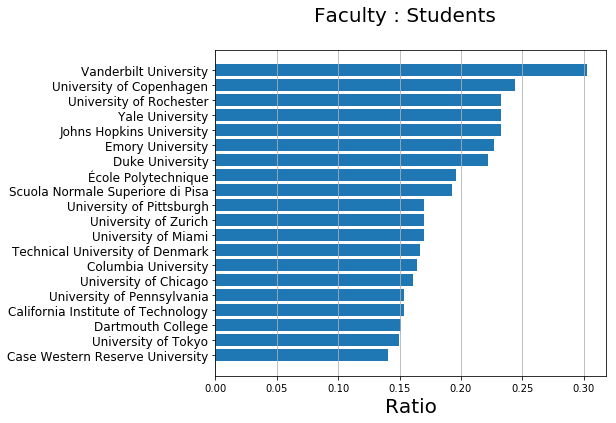

In [311]:
plot_bar('Faculty : Students', 20, times_uni_by_facstud, times_uni_by_facstud.Name)

### Question 2 (b): Which are the best universities in term of ratio of international students?

In [312]:
times_uni_by_interstud = times_universities.sort_values(
    by = 'International Students : Total Students',
    ascending=False
)

times_uni_by_interstud[['Rank', 'Name', 'International Students : Total Students']].head(10)

,Rank,Name,International Students : Total Students
24,25,London School of Economics and Political Science,0.71
178,179,University of Luxembourg,0.57
37,38,École Polytechnique Fédérale de Lausanne,0.55
7,8,Imperial College London,0.55
102,103,Maastricht University,0.50
15,16,University College London,0.49
143,143,University of St Andrews,0.48
23,24,Carnegie Mellon University,0.45
120,121,Queen Mary University of London,0.45
39,40,University of Hong Kong,0.42


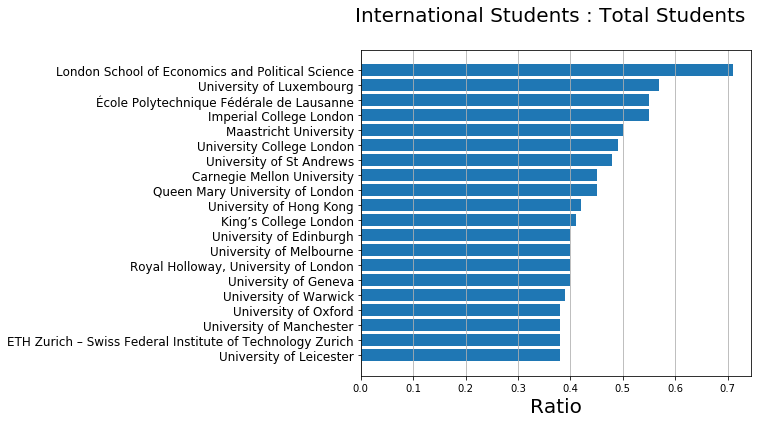

In [313]:
plot_bar('International Students : Total Students', 20, times_uni_by_interstud, times_uni_by_interstud.Name)

### Question 2 (c): Answer the previous question aggregating the data by country.

In [314]:
# Group data by country and compute the average of all fields
times_by_country = times_universities.groupby('Country').mean()

# Sort the entries of each group
times_country_facstud = times_by_country.sort_values(
    by = 'Faculty : Students',
    ascending = False
)

times_country_interstud = times_by_country.sort_values(
    by = 'International Students : Total Students',
    ascending = False
)

times_country_facstud[['Faculty : Students']].head()

,Faculty : Students
Country,
Denmark,0.160166
Italy,0.138889
Russian Federation,0.136986
Japan,0.132098
United States,0.106390


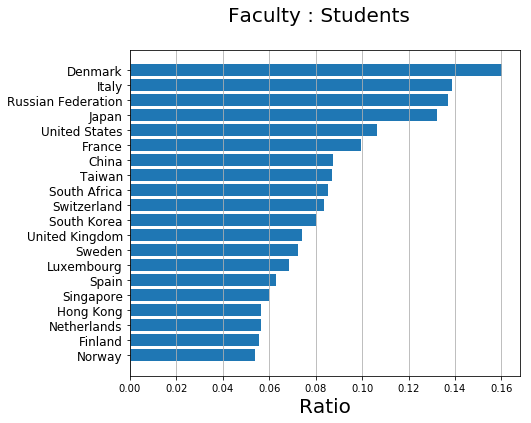

In [315]:
plot_bar('Faculty : Students', 20, times_country_facstud, times_country_facstud.index)

In [316]:
times_country_interstud[['International Students : Total Students']].head()

,International Students : Total Students
Country,
Luxembourg,0.570000
United Kingdom,0.365484
Hong Kong,0.328000
Switzerland,0.314286
Australia,0.307500


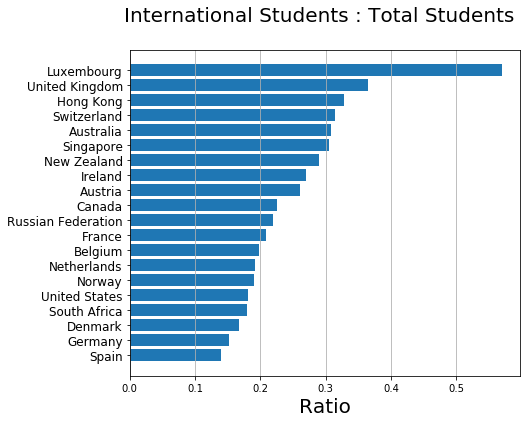

In [317]:
plot_bar('International Students : Total Students', 20, times_country_interstud, times_country_interstud.index)

### Question 2 (d): Answer the previous question aggregating the data by region.

In [318]:
# Group data by country and compute the average of all fields
times_by_region = times_universities.groupby('Region').mean()

# Sort the entries of each group
times_region_facstud = times_by_region.sort_values(
    by = 'Faculty : Students',
    ascending = False
)

times_region_interstud = times_by_region.sort_values(
    by = 'International Students : Total Students',
    ascending = False
)

times_region_facstud[['Faculty : Students']]

,Faculty : Students
Region,
North America,0.101655
Africa,0.085470
Asia,0.080345
Europe,0.065952
Oceania,0.039895


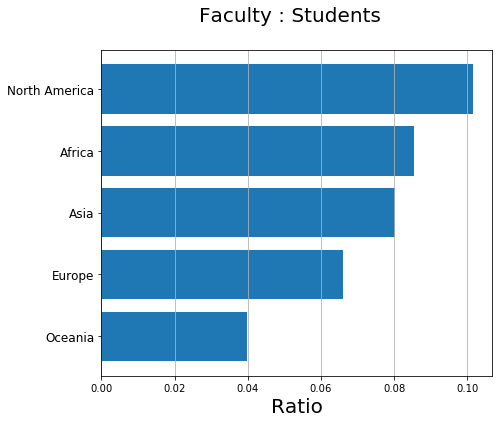

In [319]:
plot_bar('Faculty : Students', 5, times_region_facstud, times_region_facstud.index)

In [320]:
times_region_interstud[['International Students : Total Students']]

,International Students : Total Students
Region,
Oceania,0.305556
Europe,0.244653
North America,0.185588
Africa,0.180000
Asia,0.165238


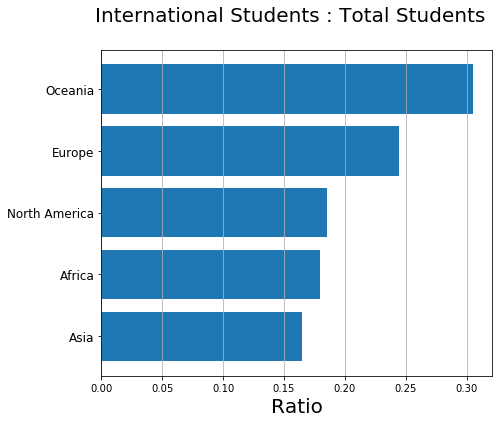

In [321]:
plot_bar('International Students : Total Students', 5, times_region_interstud, times_region_interstud.index)

## Question 3: Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.
### Strategy:
1. Names from the two datasets can differ due to abbreviated names in parantheses, unicode vs. ascii characters, definite articles, and spacing. Thus, we create a function (just below) that removes parantheses and abbreviations, changes all characters to ascii, removes "the", and removes all spaces. In essence, we only have strings. 
2. We found that there are still 12 universities which have not merged, so we do this manually.

In [322]:
import re
import unicodedata

In [323]:
# ***Dark magic***
# Parse strings to make name matching easier, involving unicode, ascii codec, regular expression
# 1. Remove strings surrounded by parentheses
# 2. Remove leading article "The " if exists
# 3. Transform unicode characters ascii
# 4. Keep only alphabets
def dark_magic(name):
    name_mod = re.match(r"^([^()]*)(?:\s+\(.*\))?",name).group(1)
    name_noarticle = name_mod.replace("The ", "")
    name_toascii = unicodedata.normalize('NFD', name_noarticle).encode('ascii', 'ignore').decode("ascii")
    name_alpha = re.findall(r"[a-zA-Z]*", name_toascii)
    return ''.join(name_alpha)

print('Example:')
print('Before: École Polytechnique Fédérale de Lausanne (EPFL)')
print('After:  ' + dark_magic('École Polytechnique Fédérale de Lausanne (EPFL)'))

Example:
Before: École Polytechnique Fédérale de Lausanne (EPFL)
After:  EcolePolytechniqueFederaledeLausanne


In [324]:
# Clean up strings "Name"
top_names = pd.Series([dark_magic(top_ranking_universities.loc[i]['Name']) for i in range(200)])
top_ranking_universities['Name_mod'] = top_names

times_names = pd.Series([dark_magic(times_universities.loc[i]['Name']) for i in range(200)])
times_universities['Name_mod'] = times_names

In [325]:
# For the 13 universities that still have some small differences and will not merge:
# Convert the name in 'Name_mod' for the topuniversities dataframe to the name from timeshighereducation.
top_ranking_universities.replace(inplace=True, to_replace={
    'ETHZurichSwissFederalInstituteofTechnology':
    'ETHZurichSwissFederalInstituteofTechnologyZurich',
    'FreieUniversitaetBerlin':
    'FreeUniversityofBerlin',
    'HumboldtUniversitatzuBerlin':
    'HumboldtUniversityofBerlin',
    'KITKarlsruheInstituteofTechnology':
    'KarlsruheInstituteofTechnology',
    'KAISTKoreaAdvancedInstituteofScienceTechnology':
    'KoreaAdvancedInstituteofScienceandTechnology',
    'LudwigMaximiliansUniversitatMunchen':
    'LMUMunich',
    'PohangUniversityofScienceAndTechnology':
    'PohangUniversityofScienceandTechnology',
    'ScuolaSuperioreSantAnnaPisadiStudiUniversitariediPerfezionamento':
    'ScuolaSuperioreSantAnna',
    'TechnischeUniversitatBerlin':
    'TechnicalUniversityofBerlin',
    'TrinityCollegeDublinUniversityofDublin':
    'TrinityCollegeDublin',
    'UCL':
    'UniversityCollegeLondon',
    'UniversityofNorthCarolinaChapelHill':
    'UniversityofNorthCarolinaatChapelHill',
    'WageningenUniversity':
    'WageningenUniversityResearch'})

In [431]:
# This is the final merged dataframe. Columns from the topuniversities data end in "_top" and 
# columns from the timeshighereducation data end in "_tim". We inner merge to keep only the 
# universities that exist in both datasets.
ranks = pd.merge(top_ranking_universities, times_universities, how='inner', on='Name_mod', suffixes=('_top','_tim'))
ranks.head()

,Country_top,Name_top,No. of International Faculty,No. of International Students,No. of Total Faculty,No. of Total Students_top,Rank_top,Region_top,Faculty : Students_top,International Students : Total Students_top,Name_mod,Aliases,Country_tim,Faculty : Students_tim,International Students : Total Students_tim,Name_tim,No. of Total Students_tim,Rank_tim,Region_tim
0,United States,Massachusetts Institute of Technology (MIT),1679.0,3717.0,2982.0,11067.0,1,North America,0.269450,0.335863,MassachusettsInstituteofTechnology,Massachusetts Institute of Technology,United States,0.114943,0.34,Massachusetts Institute of Technology,11177,5,North America
1,United States,Stanford University,2042.0,3611.0,4285.0,15878.0,2,North America,0.269870,0.227422,StanfordUniversity,Stanford University,United States,0.133333,0.22,Stanford University,15845,3,North America
2,United States,Harvard University,1311.0,5266.0,4350.0,22429.0,3,North America,0.193945,0.234785,HarvardUniversity,Harvard University,United States,0.112360,0.26,Harvard University,20326,6,North America
3,United States,California Institute of Technology (Caltech),350.0,647.0,953.0,2255.0,4,North America,0.422616,0.286918,CaliforniaInstituteofTechnology,California Institute of Technology caltech,United States,0.153846,0.27,California Institute of Technology,2209,3,North America
4,United Kingdom,University of Cambridge,2278.0,6699.0,5490.0,18770.0,5,Europe,0.292488,0.356899,UniversityofCambridge,University of Cambridge,United Kingdom,0.091743,0.35,University of Cambridge,18389,2,Europe


### Question 4: Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

### Strategy:

To find useful insights in the data, we compute the pearson correlation coefficient between pairs of variables (e.g., Rank_top vs No. International Faculty, No. of International Students vs. No. International Faculty, etc. etc.)


In [328]:
cols = [
    'Name_mod',
    'Country_top',
    'Region_top',
    
    'Rank_tim',
    'Rank_top',
    
    'Faculty : Students_tim',
    'International Students : Total Students_tim',
    'No. of Total Students_tim',
    
    'Faculty : Students_top',
    'International Students : Total Students_top',
    'No. of International Faculty',
    'No. of International Students',
    'No. of Total Faculty',
    'No. of Total Students_top']
variables = ranks[cols].reset_index(drop=True)
variables['Region_top'] = variables['Region_top'].astype('category')

In [473]:
# Remove rows with nans (NYU)
variables.drop(variables.isnull().values.nonzero()[0], inplace=True)
variables

,Name_mod,Country_top,Region_top,Rank_tim,Rank_top,Faculty : Students_tim,International Students : Total Students_tim,No. of Total Students_tim,Faculty : Students_top,International Students : Total Students_top,No. of International Faculty,No. of International Students,No. of Total Faculty,No. of Total Students_top
0,MassachusettsInstituteofTechnology,United States,North America,5,1,0.114943,0.34,11177,0.269450,0.335863,1679.0,3717.0,2982.0,11067.0
1,StanfordUniversity,United States,North America,3,2,0.133333,0.22,15845,0.269870,0.227422,2042.0,3611.0,4285.0,15878.0
2,HarvardUniversity,United States,North America,6,3,0.112360,0.26,20326,0.193945,0.234785,1311.0,5266.0,4350.0,22429.0
3,CaliforniaInstituteofTechnology,United States,North America,3,4,0.153846,0.27,2209,0.422616,0.286918,350.0,647.0,953.0,2255.0
4,UniversityofCambridge,United Kingdom,Europe,2,5,0.091743,0.35,18389,0.292488,0.356899,2278.0,6699.0,5490.0,18770.0
5,UniversityofOxford,United Kingdom,Europe,1,6,0.089286,0.38,20409,0.342292,0.372870,2964.0,7353.0,6750.0,19720.0
6,UniversityCollegeLondon,United Kingdom,Europe,16,7,0.095238,0.49,30304,0.204151,0.477928,2554.0,14854.0,6345.0,31080.0
7,ImperialCollegeLondon,United Kingdom,Europe,8,8,0.087719,0.55,15857,0.244251,0.543567,2071.0,8746.0,3930.0,16090.0
8,UniversityofChicago,United States,North America,9,9,0.161290,0.25,13525,0.180645,0.249244,635.0,3379.0,2449.0,13557.0
9,ETHZurichSwissFederalInstituteofTechnologyZurich,Switzerland,Europe,10,10,0.068493,0.38,19233,0.125006,0.381681,1886.0,7563.0,2477.0,19815.0


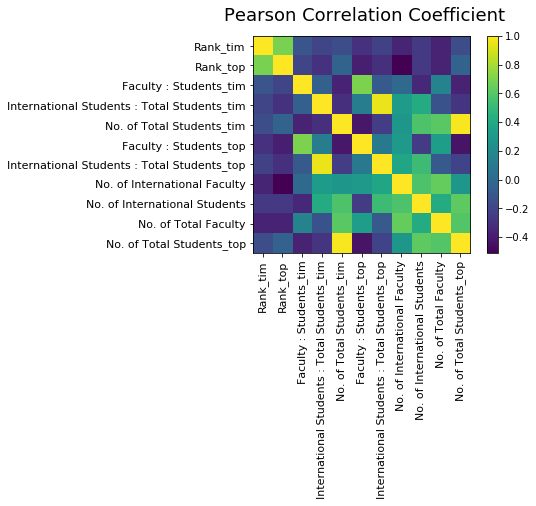

In [457]:
# Compute and plot correlation
cor_mat = np.corrcoef(variables.iloc[:,3:].transpose())
plt.imshow((cor_mat))
plt.suptitle('Pearson Correlation Coefficient', fontsize=18)
plt.gca().set_yticks(np.arange(cor_mat.shape[0]))
plt.gca().set_yticklabels(variables.columns[3:], fontsize=11)
plt.gca().set_xticks(np.arange(cor_mat.shape[0]))
plt.gca().set_xticklabels(variables.columns[3:], fontsize=11, rotation=90)
plt.colorbar()
plt.show()

In [460]:
# A list containing the same data as above, sorted by the value of correlation
lst = np.array([[(cor_mat[i,j]), variables.columns[i+3], variables.columns[j+3]]
                for i in range(cor_mat.shape[0]) for j in range(i+1, cor_mat.shape[1])])
idx = np.argsort(lst[:,0])
pd.DataFrame(lst[idx[::-1],:])

,0,1,2
0,0.982892819583,No. of Total Students_tim,No. of Total Students_top
1,0.954945988451,International Students : Total Students_tim,International Students : Total Students_top
2,0.699562023691,Faculty : Students_tim,Faculty : Students_top
3,0.693218654992,Rank_tim,Rank_top
4,0.644352258825,No. of International Faculty,No. of Total Faculty
5,0.627861012416,No. of International Students,No. of Total Students_top
6,0.612146842898,No. of Total Students_tim,No. of Total Faculty
7,0.595051652232,No. of Total Faculty,No. of Total Students_top
8,0.579328772285,No. of International Faculty,No. of International Students
9,0.578488915862,No. of Total Students_tim,No. of International Students


### Analysis of Pearson Correlation
At the first glance, there seems to be a lot of columns having very high correlation. However, after taking a closer look, they are actually columns containing the same information from the two different website, e.g. rank from Top University and from THE. Therefore, we focus only on those non-trivial pair of columns. We see that the rank in topuniversity and number of international faculty has a negative linear correlation of approximately -0.51. Also, there is a 0.58 positive linear correlation between the number of international faculty and the number of international students.

In [464]:
# Helper function
def plot_scatter(df, x_col_name, y_col_name, title):
    x, y = df[x_col_name], df[y_col_name]
    plt.scatter(x, y)
    plt.gca().set_xlabel(x_col_name)
    plt.gca().set_ylabel(y_col_name)
    plt.gca().set_title(title)

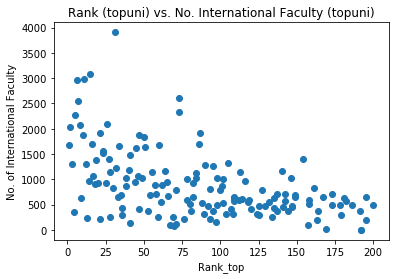

In [465]:
plot_scatter(variables, 'Rank_top', 'No. of International Faculty', 'Rank (topuni) vs. No. International Faculty (topuni)')

### Analysis: topuniversities.com ranking vs no. of international faculty

We observed that the pearson correlation coefficient between Rank_top and No. of International Faculty was -0.51. Although the relationship between the variables is not a strong negative correlation, we can see in the scatter plot above that schools that have a higher number of international faculty members tend to be higher in rank. We can imagine that top schools will recruit the best faculty in the world, so the number of international faculty may be higher for these schools.

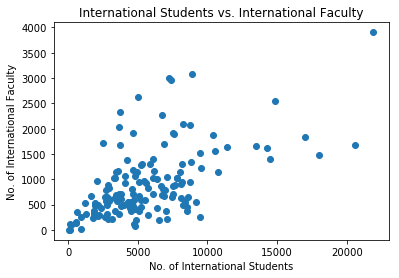

In [467]:
plot_scatter(variables, 'No. of International Students', 'No. of International Faculty', 'International Students vs. International Faculty')

### Analysis: International Students vs. International Faculty

We observed that the PCC between number of international students and international faculty was 0.58. This is a moderate positive linear correlation between the variables. In the scatter plot above there is a trend that shows that as the number of international students increases in a university, so does the number of international students. 

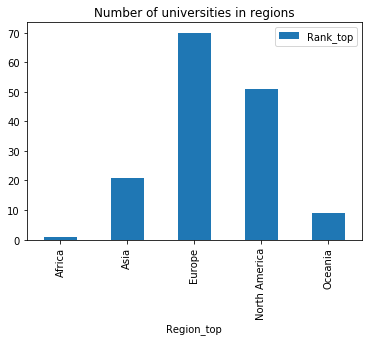

In [474]:
# Try to get scatter plot with categorical data, but pandas returns KeyError
# don't know how to solve
# variables.plot.scatter('Rank_top','Region_top')
variables.groupby('Region_top').count()[['Rank_top']].plot(kind='bar', title = 'Number of universities in regions')


### Analysis: Number of universities in regions

We were interested in seeing where the top universities in our merged dataframe are in the world. We see that most of the top universities are in Europe, then North America, Asia, Oceania, and Africa. We imagined that most of the top universities would be located in Europe and North America, as our initial analysis of the separate datasets showed that the top 10 universities were mainly in Western Europe and North America. We speculate that this is because the two regions have more resources to support the best students and faculty. 

### Question 5: Can you find the best university taking in consideration both rankings? Explain your approach.

To find the best university taking into consideration both rankings we want to take the average of the ranks and sort by this average.

1. Because we have removed universities that do not appear in both rankings, we need to update the rankings in the topuniversities subset and timeshighereducation subset. 
2. In order to do this, we first sort the merged dataframe by the rankings from topuniversities. 
3. Then we rank the universities with a value between 0 and 1, where all values are equally spaced. 0 is the best university, and 1 is the last university. 
3. We do the same for the timeshighereducation ranking. 
4. Finally, for each university, we take the mean of the mapped topuniversity ranking and the mapped timeshighereducation ranking. 
5. We sort by this mean and map each university to a rank between 1 and 153, where ties result in the same rank value.

In [346]:
# 2. We sort the merged dataframe by top universities rankings (Rank_top)
compare_ranks = ranks[['Name_top', 'Rank_top', 'Rank_tim']]
top_ranks = compare_ranks.sort_values(by = 'Rank_top')

# 3. We map the universities to equally spaced values between 0 and 1
top_ranks['Rank_top'] = np.linspace(0, 1, num = compare_ranks.shape[0])
top_ranks.head()

,Name_top,Rank_top,Rank_tim
0,Massachusetts Institute of Technology (MIT),0.000000,5
1,Stanford University,0.006579,3
2,Harvard University,0.013158,6
3,California Institute of Technology (Caltech),0.019737,3
4,University of Cambridge,0.026316,2


In [348]:
# 4. We do the same as above with timeshighereducation rankings
times_ranks = top_ranks.sort_values(by = 'Rank_tim')
times_ranks['Rank_tim'] = np.linspace(0, 1, num = compare_ranks.shape[0])
times_ranks.head()

,Name_top,Rank_top,Rank_tim
5,University of Oxford,0.032895,0.000000
4,University of Cambridge,0.026316,0.006579
1,Stanford University,0.006579,0.013158
3,California Institute of Technology (Caltech),0.019737,0.019737
0,Massachusetts Institute of Technology (MIT),0.000000,0.026316


In [397]:
# 5. We take the mean of the new ranks between 0 and 1
times_ranks['mean_rank'] = times_ranks[['Rank_top', 'Rank_tim']].mean(axis = 1)

# 6. We sort by this mean_rank and map each university to a rank between 1 and 153, 
# where ties result in the same rank value.
combined_rank = times_ranks.sort_values(by = 'mean_rank')
combined_rank['final_rank'] = np.linspace(1, combined_rank.shape[0], num = combined_rank.shape[0])

# Group universities with the same mean value (these are ties). Then assign with the same rank.
combined_rank['final_withties'] = combined_rank.groupby('mean_rank')['final_rank'].transform(lambda group: group.min())
combined_rank[['Name_top', 'Rank_top', 'Rank_tim', "mean_rank", "final_withties"]].head()

,Name_top,Rank_top,Rank_tim,mean_rank,final_withties
1,Stanford University,0.006579,0.013158,0.009868,1.0
0,Massachusetts Institute of Technology (MIT),0.000000,0.026316,0.013158,2.0
5,University of Oxford,0.032895,0.000000,0.016447,3.0
4,University of Cambridge,0.026316,0.006579,0.016447,3.0
3,California Institute of Technology (Caltech),0.019737,0.019737,0.019737,5.0


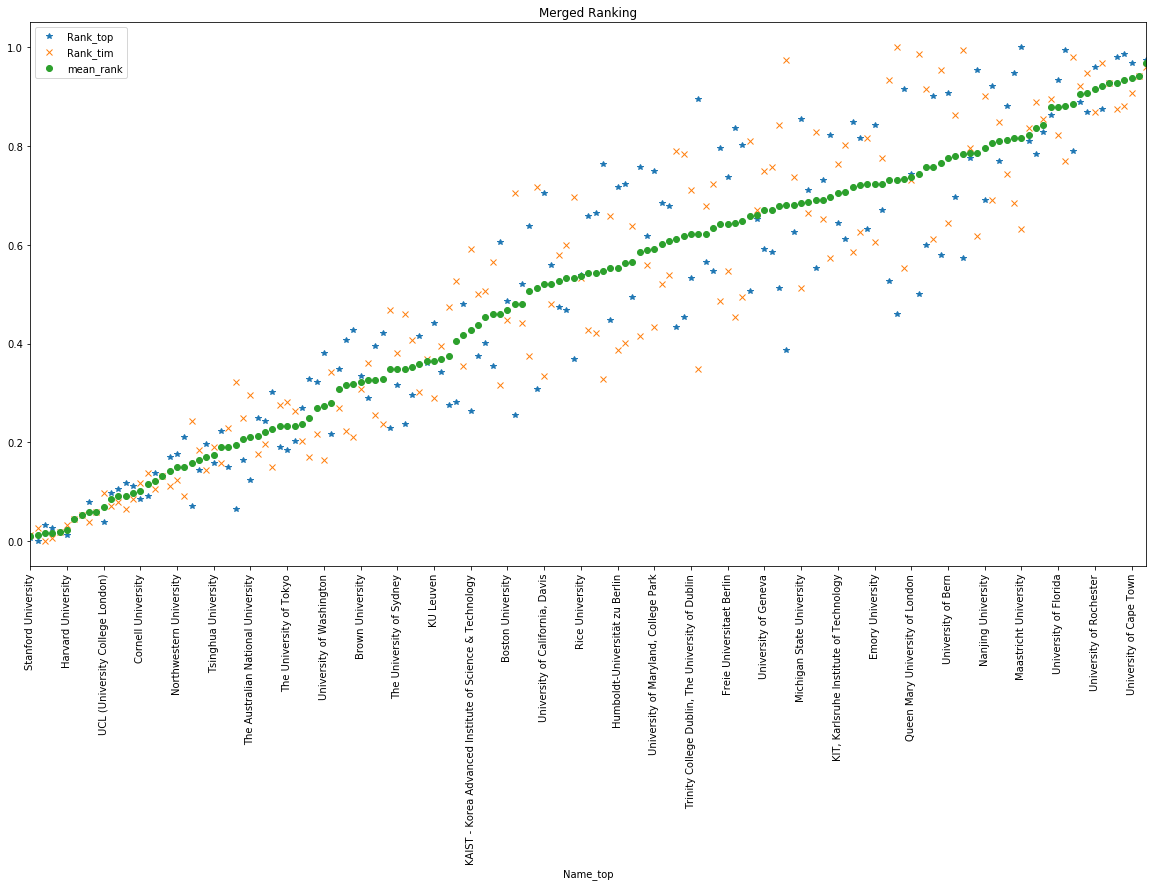

In [394]:
# Plot topuniversity rankings and timeshighereducation rankings to observe trend
import matplotlib.ticker as plticker
combined_ranks = combined_rank.set_index('Name_top')
fig, ax = plt.subplots()
loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plot = combined_ranks[['Rank_top', 'Rank_tim', 'mean_rank']].plot(ax=ax, style = ['*', 'x', 'o'], rot =  90, figsize =(20, 10), fontsize = 10, title = "Merged Ranking")


### Brief summary : NOTE - Our plot represents the best university as 0, and the last university as 1.
Here, we can see that the rankings provided by the two sources do not diverge far from the mean rank for about the top 30 universities. The two rankings slowly begin to diverge at this point, and as the mean university ranking becomes worse, the the difference between the topuniversities and timeshighereducation rankings grows. 

The combined ranking shows that Stanford University is the best university.

In [428]:
# This is the combined best university ranking
combined_ranks.rename(columns = {'final_withties':'Combined Mean Ranking'}, inplace = True)
combined_ranks.index = combined_ranks.index.rename("University")
combined_ranks[['Combined Mean Ranking']].head(20)

,Combined Mean Ranking
University,
Stanford University,1.0
Massachusetts Institute of Technology (MIT),2.0
University of Oxford,3.0
University of Cambridge,3.0
California Institute of Technology (Caltech),5.0
Harvard University,6.0
Imperial College London,7.0
University of Chicago,8.0
Princeton University,9.0
